# Investigating changes in mixed layer depth at Sørvest-F and Norvest-C due to offshore wind farms

__Kjersti Stangeland - Summer 2025 - The Norwegian Meteorological Insitute__

#### The project - Havvind

A scenario with Norwegian wind farms at sea has been developed in a collaboration with NVE. The period 2/2-2022 til 30/6-2022 is simulated with MEPS, WaveWatch III, og Norkyst v3. There are to versions of the simulations:
* A control run based of the current situation with no Norwegian wind farms at sea
* An experiment with simulated wind farms.

In the experiments, the only direct parametrization of the windmills are in MEPS. Therefore, effects on waves and ocean cirulation is indirectly seen through changed surface fluxes.

__Details on the wind farms:__
* Height of turbines is 165 m
* Radius 143 m
* 2.5 km distance between turbines
* 5 different farms simulated along the Norwegian coast

__Sørvest F__
* A wind farm south west of Norway
* 1x1500MW + 2x2100MW 
* 1630 km²
* 258 turbines

__Nordvest C__
* A wind farm north west of Norway, close to Kristiansund
* 4x1500 MW
* 1720 km²
* 280 turbines

### Mixed layer depth

The mixed layer of the upper ocean is the first meters of the water column where the potential density is homogeneously mixed. Below this layer, the density increases linearily in the pycnocline, and below is the deep ocean. The depth of the mixed layer depends on available energy for mixing, i.e. turbulence and convection. Thus, the MLD exhibits seasonality with typically larger values in the winter during strong convection in the water column.

As in Treguier et al. (2023), I will use the potential density threshold method to determine the MLD. The method, also found in the `xroms` Python package, determines MLD as the depth where the potential density exceeds a threshold of $\sigma_0 + 0.003 kgm^{-3}$. In the shallow North sea, MLD might exceed the local water depth. In my method below I set the MLD equal to the local water depth at times where the whole water column of a grid point is mixed. $\sigma_0$, is taken as the potential density of the upper most model layer of the grid point. Salinity and temperature has been interpolated from s-levels to z-dephts, and thus the upper most level of potential density is fairly close to the surface. Note: I've seen in other papers that the reference density is taken at 10 m depth, whereas `xroms` uses the uppermost level. 


Treguier, A. M., de Boyer Montégut, C., Bozec, A., Chassignet, E. P., Fox-Kemper, B., McC. Hogg, A., Iovino, D., Kiss, A. E., Le Sommer, J., Li, Y., Lin, P., Lique, C., Liu, H., Serazin, G., Sidorenko, D., Wang, Q., Xu, X., and Yeager, S.: The mixed-layer depth in the Ocean Model Intercomparison Project (OMIP): impact of resolving mesoscale eddies, Geosci. Model Dev., 16, 3849–3872, https://doi.org/10.5194/gmd-16-3849-2023, 2023.

In [1]:
%load_ext autoreload
%autoreload 2

from Rossby_deformation.get_turbine_coords import get_turbine_coords
from Rossby_deformation.funcs import *
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import cartopy.feature as cfeature

mplstyle.use(['ggplot', 'fast'])

In [2]:
# Making a grid
path = '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-03/norkyst_avg_0001.nc'
fid = Dataset(path)
grid = SGrid(fid)
del fid

In [3]:
# Opening the turbine coordinates as a xArray DataSet
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')
nordvest_C = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Nordvest_C.txt')

In [4]:
# Square around wind park
min_lon_SV = np.min(sorvest_F.coordinates[:,0].values)
min_lat_SV = np.min(sorvest_F.coordinates[:,1].values)
max_lon_SV = np.max(sorvest_F.coordinates[:,0].values)
max_lat_SV = np.max(sorvest_F.coordinates[:,1].values)

area_lon_SV = [min_lon_SV, max_lon_SV]
area_lat_SV = [min_lat_SV, max_lat_SV]

In [5]:
# Square around wind park
min_lon_NV = np.min(nordvest_C.coordinates[:,0].values)
min_lat_NV = np.min(nordvest_C.coordinates[:,1].values)
max_lon_NV = np.max(nordvest_C.coordinates[:,0].values)
max_lat_NV = np.max(nordvest_C.coordinates[:,1].values)

area_lon_NV = [min_lon_NV, max_lon_NV]
area_lat_NV = [min_lat_NV, max_lat_NV]

In [6]:
# Extracting paths to files containing the computed Rossby deformation radius
# Note: I'm using the reference datasets and not the experiments
# Rossby deformation radius computed from the experiment datasets are found in output_bdr/EXP

filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_bdr/REF')

# Only using June because we want the largest Rossby radius
months = {
"06": 30   # June
}

files=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [7]:
# Internal Rossby radius of June - from area of wind parks
R1_june_SV = monthly_mean_area(files, grid, area_lon_SV, area_lat_SV)
R1_june_SV = R1_june_SV.gamma_r

In [8]:
# Internal Rossby radius of June - from area of wind parks
R1_june_NV = monthly_mean_area(files, grid, area_lon_NV, area_lat_NV)
R1_june_NV = R1_june_NV.gamma_r

The script `mld.py` wrote output files of potential desnity at z-levels and MLD. Unfortunately, the so-called 'z_rho' dimension in the outputs are just the number of z-levels interpolated to, not the actual depths. So below I fetch the zlevs which the data was interpolated to. Maybe consider to re-do the caluclations and return the z-levels? The interpolation was handled to take into account the local water depth, so even though zlevs range to 3000 m depth, potential density and MLD in the region of Sørvest-F is done to local depths. 

In [9]:
zlevs = np.arange(0,51,1)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(52,102,2), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(105,305,5), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(520,1020,20), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(1050,3050,50), axis =0)

zlevs = zlevs[np.where(zlevs<=np.max(grid.h))]
zlevs = np.array(zlevs)*-1.

In [10]:
# Extracting filepaths to MLD for the reference runs

filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_mld/REF')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files_ref=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_mld.nc'
        files_ref.append(filefolder[0]+file_path)

In [11]:
# Extracting filepaths to MLD for the experiments

filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_mld/EXP')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files_exp=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/EXP_{month}_norkyst_avg_{day_str}_mld.nc'
        files_exp.append(filefolder[0]+file_path)

In [12]:
# MLD and potential dens at Sørvest-F - study area is 60R1x60R1 around wind farm.
# Area lon/lat is the extent of the study area
lon_SV, lat_SV, ref_SV = make_study_area(files_ref, grid, area_lon_SV, area_lat_SV, R1_june_SV)
lon_SV, lat_SV, exp_SV = make_study_area(files_exp, grid, area_lon_SV, area_lat_SV, R1_june_SV)

In [13]:
# MLD and potential dens at Sørvest-F - study area is 60R1x60R1 around wind farm.
# Area lon/lat is the extent of the study area
lon_NV, lat_NV, ref_NV = make_study_area(files_ref, grid, area_lon_NV, area_lat_NV, R1_june_NV)
lon_NV, lat_NV, exp_NV = make_study_area(files_exp, grid, area_lon_NV, area_lat_NV, R1_june_NV)

In [14]:
# Monthly mean of MLD
mmean_mld_ref_SV = ref_SV.mld.resample(ocean_time='1M').mean(dim='ocean_time')
mmean_mld_exp_SV = exp_SV.mld.resample(ocean_time='1M').mean(dim='ocean_time')

In [15]:
# Monthly mean of MLD
mmean_mld_ref_NV = ref_NV.mld.resample(ocean_time='1M').mean(dim='ocean_time')
mmean_mld_exp_NV = exp_NV.mld.resample(ocean_time='1M').mean(dim='ocean_time')

In [16]:
months = ['Feb', 'Mar', 'Apr', 'May', 'Jun']

In [17]:
""" proj = ccrs.Mercator()
fig, ax = plt.subplots(5, 2, figsize=(5, 10), subplot_kw={'projection': proj})

plt.subplots_adjust(wspace=0.2, hspace=0.5)
cmap = 'cmo.deep'

for i in range(5):
    for j in range(2):
        axs = ax[i, j]
        axs.set_extent([area_lon[0], area_lon[1], area_lat[0], area_lat[1]])

        for coord in sorvest_F['coordinates']:
            axs.plot(coord[0], coord[1],
                     transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)

        gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                           color='lightgray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        if j == 0:
            plot = axs.pcolormesh(lon, lat, mmean_mld_ref[i, :, :],
                                  transform=ccrs.PlateCarree(), cmap=cmap)
            axs.set_title(f'REF {months[i]}')
            cbar = fig.colorbar(plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
            cbar.set_label('[m]')
        else:
            plot = axs.pcolormesh(lon, lat, mmean_mld_exp[i, :, :],
                                  transform=ccrs.PlateCarree(), cmap=cmap)
            axs.set_title(f'EXP {months[i]}')
            cbar = fig.colorbar(plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
            cbar.set_label('[m]')

fig.suptitle('Monthly Mean MLD', y=0.95) """

" proj = ccrs.Mercator()\nfig, ax = plt.subplots(5, 2, figsize=(5, 10), subplot_kw={'projection': proj})\n\nplt.subplots_adjust(wspace=0.2, hspace=0.5)\ncmap = 'cmo.deep'\n\nfor i in range(5):\n    for j in range(2):\n        axs = ax[i, j]\n        axs.set_extent([area_lon[0], area_lon[1], area_lat[0], area_lat[1]])\n\n        for coord in sorvest_F['coordinates']:\n            axs.plot(coord[0], coord[1],\n                     transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)\n\n        gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,\n                           color='lightgray', alpha=0.5, linestyle='--')\n        gl.top_labels = False\n        gl.right_labels = False\n        gl.xformatter = LONGITUDE_FORMATTER\n        gl.yformatter = LATITUDE_FORMATTER\n\n        if j == 0:\n            plot = axs.pcolormesh(lon, lat, mmean_mld_ref[i, :, :],\n                                  transform=ccrs.PlateCarree(), cmap=cmap)\n            axs.

In [18]:
# Absolute difference between exp and ref
mmean_mld_diff_SV = (mmean_mld_exp_SV - mmean_mld_ref_SV)
mmean_mld_diff_NV = (mmean_mld_exp_NV - mmean_mld_ref_NV)

### Monthly mean MLD - difference between reference and experiment
The maps below shows the difference in monthly mean MLD between the reference data and experiment data. Thus, differences can be appointed to the implementation of wind farms in the experiment runs.

A change in the monthly mean MLD can be due to a change in mixing processes in the upper layer such as reduced wind stress, increased turbulence by turbine structures, changes in surface radiation balance ++. 

__Sørvest-F__:

The largest changes are seen in April, lowest changes in February. Overall the mean difference is positive, meaning that the MLD is larger in the experiments, ranging from 0.03-1 m.

When looking at the relative difference, the change is very small, around +/- 0.5 m.

Note that the MLD is calculated in such a way that if the whole water column is mixed, MLD is set to be the local water depth. So it is possible that during winter, when a shallow area is fully mixed due to convection, no change is seen.

__Nordvest-C__:

Nordvest-C is in a deeper region than Sørvest-F and thus the changes in MLD can be larger, as seen in february-march.

In [19]:
print(f'Max difference February: SV: {np.nanmax(mmean_mld_diff_SV[0,:,:].values):.4f}, NV: {np.nanmax(mmean_mld_diff_NV[0,:,:].values):.4f}')
print(f'Max difference March: SV: {np.nanmax(mmean_mld_diff_SV[1,:,:].values):.4f}, NV: {np.nanmax(mmean_mld_diff_NV[1,:,:].values):.4f}')
print(f'Max difference April: SV: {np.nanmax(mmean_mld_diff_SV[2,:,:].values):.4f}, NV: {np.nanmax(mmean_mld_diff_NV[2,:,:].values):.4f}')
print(f'Max difference May: SV: {np.nanmax(mmean_mld_diff_SV[3,:,:].values):.4f}, NV: {np.nanmax(mmean_mld_diff_NV[3,:,:].values):.4f}')
print(f'Max difference June: SV: {np.nanmax(mmean_mld_diff_SV[4,:,:].values):.4f}, NV: {np.nanmax(mmean_mld_diff_NV[4,:,:].values):.4f}')


Max difference February: SV: 4.4444, NV: 108.5926
Max difference March: SV: 5.5161, NV: 89.4194
Max difference April: SV: 10.1000, NV: 203.0667
Max difference May: SV: 3.1935, NV: 15.7097
Max difference June: SV: 2.1667, NV: 8.2000


In [20]:
print(f'Min difference February: SV: {np.nanmin(mmean_mld_diff_SV[0,:,:].values):.4f}, NV: {np.nanmin(mmean_mld_diff_NV[0,:,:].values):.4f}')
print(f'Min difference March: SV: {np.nanmin(mmean_mld_diff_SV[1,:,:].values):.4f}, NV: {np.nanmin(mmean_mld_diff_NV[1,:,:].values):.4f}')
print(f'Min difference April: SV: {np.nanmin(mmean_mld_diff_SV[2,:,:].values):.4f}, NV: {np.nanmin(mmean_mld_diff_NV[2,:,:].values):.4f}')
print(f'Min difference May: SV: {np.nanmin(mmean_mld_diff_SV[3,:,:].values):.4f}, NV: {np.nanmin(mmean_mld_diff_NV[3,:,:].values):.4f}')
print(f'Min difference June: SV: {np.nanmin(mmean_mld_diff_SV[4,:,:].values):.4f}, NV: {np.nanmin(mmean_mld_diff_NV[4,:,:].values):.4f}')

Min difference February: SV: -5.8889, NV: -126.1111
Min difference March: SV: -5.6129, NV: -59.5806
Min difference April: SV: -7.8000, NV: -32.7667
Min difference May: SV: -0.8387, NV: -26.1613
Min difference June: SV: -1.0000, NV: -6.5667


In [21]:
print(f'Mean difference February: SV: {np.nanmean(mmean_mld_diff_SV[0,:,:].values):.4f}, NV: {np.nanmean(mmean_mld_diff_NV[0,:,:].values):.4f}')
print(f'Mean difference March: SV: {np.nanmean(mmean_mld_diff_SV[1,:,:].values):.4f}, NV: {np.nanmean(mmean_mld_diff_NV[1,:,:].values):.4f}')
print(f'Mean difference April: SV: {np.nanmean(mmean_mld_diff_SV[2,:,:].values):.4f}, NV: {np.nanmean(mmean_mld_diff_NV[2,:,:].values):.4f}')
print(f'Mean difference May: SV: {np.nanmean(mmean_mld_diff_SV[3,:,:].values):.4f}, NV: {np.nanmean(mmean_mld_diff_NV[3,:,:].values):.4f}')
print(f'Mean difference June: SV: {np.nanmean(mmean_mld_diff_SV[4,:,:].values):.4f}, NV: {np.nanmean(mmean_mld_diff_NV[4,:,:].values):.4f}')

Mean difference February: SV: 0.0497, NV: 0.1309
Mean difference March: SV: 0.4331, NV: 5.3547
Mean difference April: SV: 1.1177, NV: 5.8417
Mean difference May: SV: 0.7388, NV: -0.9413
Mean difference June: SV: 0.5287, NV: -0.0122


Text(0.5, 0.98, 'Difference in monthly mean MLD - (EXP-REF)')

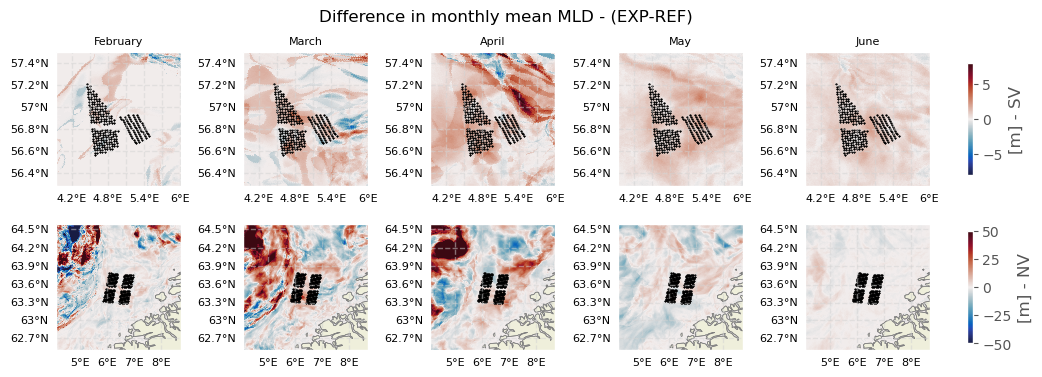

In [22]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(2, 5, figsize=(12, 4), subplot_kw={'projection': proj})

plt.subplots_adjust(wspace=0.5, hspace=0.2)

cmap = 'cmo.balance'

vmin_SV, vmax_SV = -8, 8
vmin_NV, vmax_NV = -50, 50

for i in range(5):
    axs = ax[0, i] 
    axs.set_extent([lon_SV[0], lon_SV[1], lat_SV[0], lat_SV[1]])

    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)

    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8}
    gl.ylabel_style = {'fontsize': 8} 

    plot = axs.pcolormesh(ref_SV.lon_rho, ref_SV.lat_rho, mmean_mld_diff_SV[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap,
                          vmin=vmin_SV, vmax=vmax_SV)
    axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=8)

cbar_row1 = fig.colorbar(plot, ax=ax[0], orientation='vertical', shrink=0.8, fraction=0.02, pad=0.04)
cbar_row1.set_label('[m] - SV')

for i in range(5):
    axs = ax[1, i] 
    axs.set_extent([lon_NV[0], lon_NV[1], lat_NV[0], lat_NV[1]])

    for j in range(len(nordvest_C.coordinates)):
        axs.plot(nordvest_C.coordinates[j][0], nordvest_C.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)

    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8}
    gl.ylabel_style = {'fontsize': 8} 

    plot = axs.pcolormesh(ref_NV.lon_rho, ref_NV.lat_rho, mmean_mld_diff_NV[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap,
                          vmin=vmin_NV, vmax=vmax_NV)
    #axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=8)

cbar_row2 = fig.colorbar(plot, ax=ax[1], orientation='vertical', shrink=0.8, fraction=0.02, pad=0.04)
cbar_row2.set_label('[m] - NV')

# Adding land, coastline, and borders
land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='10m', edgecolor='gray', facecolor='none')

for axs in ax.flatten():
    axs.add_feature(land)
    axs.add_feature(coastline)

fig.suptitle('Difference in monthly mean MLD - (EXP-REF)')

In [84]:
# Relative difference
mmean_mld_rel_diff_SV = ((mmean_mld_exp_SV - mmean_mld_ref_SV)/mmean_mld_ref_SV)
mmean_mld_rel_diff_NV = ((mmean_mld_exp_NV - mmean_mld_ref_NV)/mmean_mld_ref_NV)

Text(0.5, 0.98, 'Relative difference in monthly mean MLD - (EXP-REF)/REF')

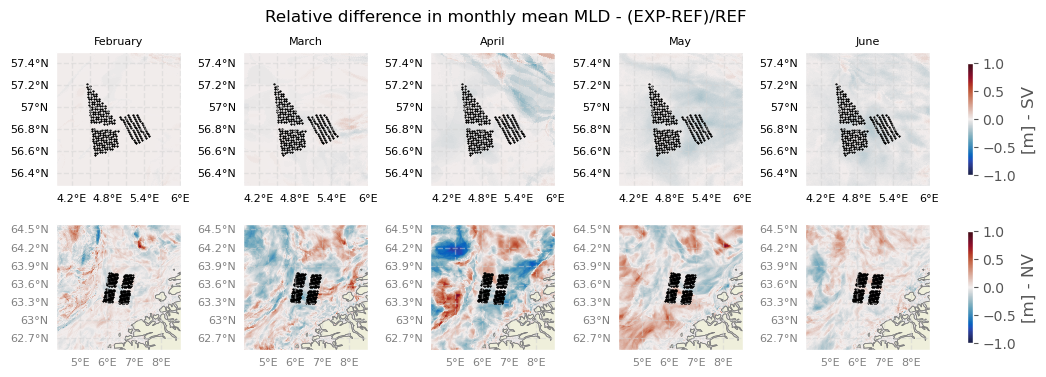

In [89]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(2, 5, figsize=(12, 4), subplot_kw={'projection': proj})

plt.subplots_adjust(wspace=0.5, hspace=0.2)

cmap = 'cmo.balance'

vmin_SV, vmax_SV = -1, 1
vmin_NV, vmax_NV = -1, 1

for i in range(5):
    axs = ax[0, i] 
    axs.set_extent([lon_SV[0], lon_SV[1], lat_SV[0], lat_SV[1]])

    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)

    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8}
    gl.ylabel_style = {'fontsize': 8} 

    plot = axs.pcolormesh(ref_SV.lon_rho, ref_SV.lat_rho, mmean_mld_rel_diff_SV[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap,
                          vmin=vmin_SV, vmax=vmax_SV)
    axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=8)

cbar_row1 = fig.colorbar(plot, ax=ax[0], orientation='vertical', shrink=0.8, fraction=0.02, pad=0.04)
cbar_row1.set_label('[m] - SV')

for i in range(5):
    axs = ax[1, i] 
    axs.set_extent([lon_NV[0], lon_NV[1], lat_NV[0], lat_NV[1]])

    for j in range(len(nordvest_C.coordinates)):
        axs.plot(nordvest_C.coordinates[j][0], nordvest_C.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)

    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

    plot = axs.pcolormesh(ref_NV.lon_rho, ref_NV.lat_rho, mmean_mld_rel_diff_NV[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap,
                          vmin=vmin_NV, vmax=vmax_NV)
    #axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=8)

cbar_row2 = fig.colorbar(plot, ax=ax[1], orientation='vertical', shrink=0.8, fraction=0.02, pad=0.04)
cbar_row2.set_label('[m] - NV')

# Adding land, coastline, and borders
land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='10m', edgecolor='gray', facecolor='none')

for axs in ax.flatten():
    axs.add_feature(land)
    axs.add_feature(coastline)

fig.suptitle('Relative difference in monthly mean MLD - (EXP-REF)/REF')

Now lets see what the profile of potential density looks like with depth. This plotting took way too long, so it was moved to a separate module and figure is found in `Figures/pd_mld_SVF_NVC.png`.

__Note!__ The potential density with depth is the mean potential density of the whole STUDY area, not just the area within the wind farms.

In [25]:
# Horizontal mean of MLD
hmmean_SV_mld_ref = mmean_mld_ref_SV.mean(dim=['eta_rho', 'xi_rho'])
hmmean_SV_mld_exp = mmean_mld_exp_SV.mean(dim=['eta_rho', 'xi_rho'])

In [26]:
# Horizontal mean of MLD
hmmean_NV_mld_ref = mmean_mld_ref_NV.mean(dim=['eta_rho', 'xi_rho'])
hmmean_NV_mld_exp = mmean_mld_exp_NV.mean(dim=['eta_rho', 'xi_rho'])

In [27]:
# Monthly mean of potential density of the area
mmean_pd_ref_SV = ref_SV.pd.resample(ocean_time='1M').mean(dim='ocean_time')
mmean_pd_exp_SV = exp_SV.pd.resample(ocean_time='1M').mean(dim='ocean_time')

# Horizontal mean
hmmean_pd_SV_ref = mmean_pd_ref_SV.mean(dim=['eta_rho', 'xi_rho'])
hmmean_pd_SV_exp = mmean_pd_exp_SV.mean(dim=['eta_rho', 'xi_rho'])

In [28]:
# Monthly mean of potential density of the area
mmean_pd_ref_NV = ref_NV.pd.resample(ocean_time='1M').mean(dim='ocean_time')
mmean_pd_exp_NV = exp_NV.pd.resample(ocean_time='1M').mean(dim='ocean_time')

# Horizontal mean
hmmean_pd_NV_ref = mmean_pd_ref_NV.mean(dim=['eta_rho', 'xi_rho'])
hmmean_pd_NV_exp = mmean_pd_exp_NV.mean(dim=['eta_rho', 'xi_rho'])

Moved the plotting to a separate module because it takes too long time to run. (2 hrs).

In [29]:
""" fig, ax = plt.subplots(2, 5, figsize=(20, 8))

n_xticks = 3

for i, axs in enumerate(ax[0]):
    axs.plot(hmmean_pd_SV_ref[i, :].values, zlevs, color='teal', label='REF')
    axs.plot(hmmean_pd_SV_exp[i, :].values, zlevs, color='darkgoldenrod', label='EXP')
    axs.set_title(months[i])
    axs.legend()
    axs.axhline(y=hmmean_SV_mld_ref[i], color='teal', alpha=0.6, linestyle='--', linewidth=2)
    axs.axhline(y=hmmean_SV_mld_exp[i], color='darkgoldenrod', alpha=0.6, linestyle='--', linewidth=2)
    axs.grid()
    axs.set_xticks(np.linspace(axs.get_xlim()[0], axs.get_xlim()[1], n_xticks))

for i, axs in enumerate(ax[1]):
    axs.plot(hmmean_pd_NV_ref[i, :].values, zlevs, color='teal', label='REF')
    axs.plot(hmmean_pd_NV_exp[i, :].values, zlevs, color='darkgoldenrod', label='EXP')
    axs.set_title(months[i])
    axs.legend()
    axs.axhline(y=hmmean_NV_mld_ref[i], color='teal', alpha=0.6, linestyle='--', linewidth=2)
    axs.axhline(y=hmmean_NV_mld_exp[i], color='darkgoldenrod', alpha=0.6, linestyle='--', linewidth=2)
    axs.grid()
    axs.set_xticks(np.linspace(axs.get_xlim()[0], axs.get_xlim()[1], n_xticks))

# Add row titles
fig.text(0.5, 0.94, 'Sørvest-F', ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.48, 'Nordvest-C', ha='center', va='center', fontsize=14, fontweight='bold')

fig.suptitle('Potential density - Sørvest-F and Nordvest-C', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('Figures/pd_mld_SVF_NVC.png') """

" fig, ax = plt.subplots(2, 5, figsize=(20, 8))\n\nn_xticks = 3\n\nfor i, axs in enumerate(ax[0]):\n    axs.plot(hmmean_pd_SV_ref[i, :].values, zlevs, color='teal', label='REF')\n    axs.plot(hmmean_pd_SV_exp[i, :].values, zlevs, color='darkgoldenrod', label='EXP')\n    axs.set_title(months[i])\n    axs.legend()\n    axs.axhline(y=hmmean_SV_mld_ref[i], color='teal', alpha=0.6, linestyle='--', linewidth=2)\n    axs.axhline(y=hmmean_SV_mld_exp[i], color='darkgoldenrod', alpha=0.6, linestyle='--', linewidth=2)\n    axs.grid()\n    axs.set_xticks(np.linspace(axs.get_xlim()[0], axs.get_xlim()[1], n_xticks))\n\nfor i, axs in enumerate(ax[1]):\n    axs.plot(hmmean_pd_NV_ref[i, :].values, zlevs, color='teal', label='REF')\n    axs.plot(hmmean_pd_NV_exp[i, :].values, zlevs, color='darkgoldenrod', label='EXP')\n    axs.set_title(months[i])\n    axs.legend()\n    axs.axhline(y=hmmean_NV_mld_ref[i], color='teal', alpha=0.6, linestyle='--', linewidth=2)\n    axs.axhline(y=hmmean_NV_mld_exp[i], colo

In [30]:
# Time evolution of mixed layer depth in study area
mld_SV_ref = ref_SV.mld.mean(dim=['eta_rho', 'xi_rho'])
mld_SV_exp = exp_SV.mld.mean(dim=['eta_rho', 'xi_rho'])

mld_NV_ref = ref_NV.mld.mean(dim=['eta_rho', 'xi_rho'])
mld_NV_exp = exp_NV.mld.mean(dim=['eta_rho', 'xi_rho'])

Text(0, 0.5, 'Depth [m]')

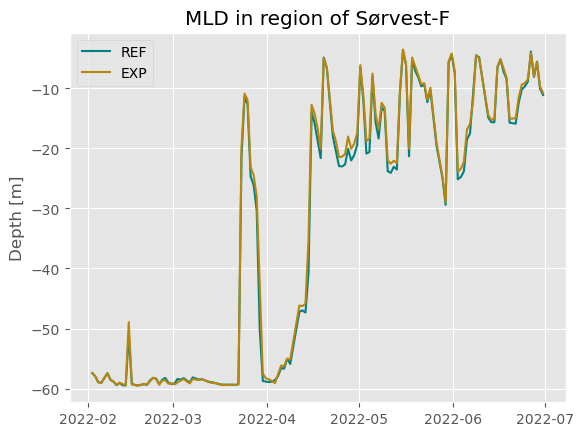

In [31]:
fig, ax = plt.subplots()

ax.plot(mld_SV_ref.ocean_time, mld_SV_ref, color='teal', label='REF')
ax.plot(mld_SV_ref.ocean_time, mld_SV_exp, color='darkgoldenrod', label='EXP')
ax.set_title('MLD in region of Sørvest-F')
ax.legend()
ax.set_ylabel('Depth [m]')

Text(0, 0.5, 'Depth [m]')

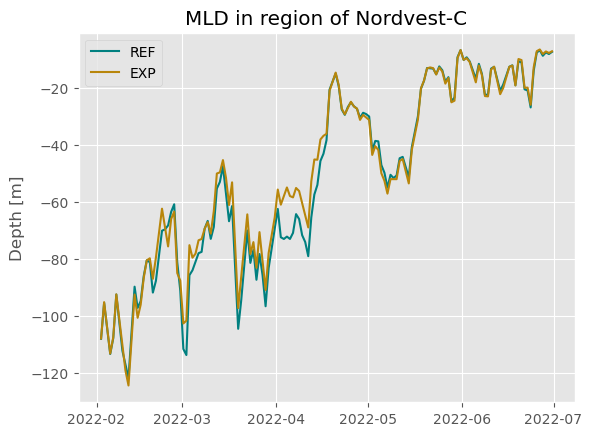

In [32]:
fig, ax = plt.subplots()

ax.plot(mld_NV_ref.ocean_time, mld_NV_ref, color='teal', label='REF')
ax.plot(mld_NV_ref.ocean_time, mld_NV_exp, color='darkgoldenrod', label='EXP')
ax.set_title('MLD in region of Nordvest-C')
ax.legend()
ax.set_ylabel('Depth [m]')

In [33]:
print(f'Standard deviation of MLD at Sørvest-F ref.: {np.std(mld_SV_ref):.2f}')
print(f'Standard deviation of MLD at Sørvest-F exp.: {np.std(mld_SV_exp):.2f}')

Standard deviation of MLD at Sørvest-F ref.: 21.97
Standard deviation of MLD at Sørvest-F exp.: 22.22


In [34]:
print(f'Standard deviation of MLD at Nordvest-C ref.: {np.std(mld_NV_ref):.2f}')
print(f'Standard deviation of MLD at Nordvest-C exp.: {np.std(mld_NV_exp):.2f}')

Standard deviation of MLD at Nordvest-C ref.: 32.55
Standard deviation of MLD at Nordvest-C exp.: 31.15


In [35]:
path = '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-03/norkyst_avg_0001.nc'
ds = xr.open_dataset(path)
depth = ds.h

In [36]:
def get_depth_of_studyarea(da, ds):
    lon_da = da.lon_rho
    lat_da = da.lat_rho
    lon_ds = ds.lon_rho
    lat_ds = ds.lat_rho

    lon_min = lon_ds.min().item()
    lon_max = lon_ds.max().item()
    lat_min = lat_ds.min().item()
    lat_max = lat_ds.max().item()

    mask = ((lon_da >= lon_min) & (lon_da <= lon_max) & 
            (lat_da >= lat_min) & (lat_da <= lat_max))

   
    mask_da = xr.DataArray(mask, dims=('eta_rho', 'xi_rho'))

    masked_da = da.where(mask_da, drop=True)

    return masked_da

In [37]:
depth_SV = get_depth_of_studyarea(depth, ref_SV)
depth_NV = get_depth_of_studyarea(depth, ref_NV)

In [38]:
print('Depths at Sørvest-F:')
print(f'Mean depth: {depth_SV.mean():.2f}')
print(f'Max. depth: {depth_SV.max():.2f}')
print(f'Min. depth: {depth_SV.min():.2f}')

Depths at Sørvest-F:
Mean depth: 72.19
Max. depth: 399.61
Min. depth: 29.25


In [39]:
print('Depths at Nordvest-C:')
print(f'Mean depth: {depth_NV.mean():.2f}')
print(f'Max. depth: {depth_NV.max():.2f}')
print(f'Min. depth: {depth_NV.min():.2f}')

Depths at Nordvest-C:
Mean depth: 450.38
Max. depth: 2848.90
Min. depth: 10.00


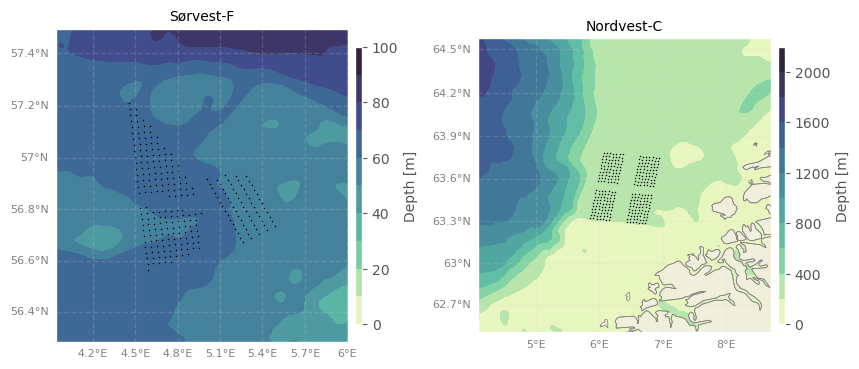

In [88]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': proj}, figsize=(10, 6))
cmap = 'cmo.deep'

min_range_SV, max_range_SV = 0, 300
min_range_NV, max_range_NV = 0, 3000 

ax[0].set_extent([lon_SV[0], lon_SV[1], lat_SV[0], lat_SV[1]])
contour1 = ax[0].contourf(depth_SV.lon_rho, depth_SV.lat_rho, depth_SV, transform=ccrs.PlateCarree(), 
                          cmap=cmap, levels=np.arange(0, 110, 10))
ax[0].set_title('Sørvest-F', fontsize=10)

for j in range(len(sorvest_F.coordinates)):
    ax[0].plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
             transform=ccrs.PlateCarree(), color='black', marker='*', markersize=0.5)

ax[1].set_extent([lon_NV[0], lon_NV[1], lat_NV[0], lat_NV[1]])
contour2 = ax[1].contourf(depth_NV.lon_rho, depth_NV.lat_rho, depth_NV, transform=ccrs.PlateCarree(), 
                          cmap=cmap, levels=np.arange(0, 2400, 200))
ax[1].set_title('Nordvest-C', fontsize=10)

for j in range(len(nordvest_C.coordinates)):
    ax[1].plot(nordvest_C.coordinates[j][0], nordvest_C.coordinates[j][1], 
             transform=ccrs.PlateCarree(), color='black', marker='*', markersize=0.5)

cbar1 = fig.colorbar(contour1, ax=ax[0], orientation='vertical', pad=0.02, aspect=40, shrink=0.6)
cbar1.set_label('Depth [m]', fontsize=10)

cbar2 = fig.colorbar(contour2, ax=ax[1], orientation='vertical', pad=0.02, aspect=40, shrink=0.6)
cbar2.set_label('Depth [m]', fontsize=10)

#cbar1.set_ticks([min_range_SV, (min_range_SV + max_range_SV) / 2, max_range_SV])
#cbar2.set_ticks([min_range_NV, (min_range_NV + max_range_NV) / 2, max_range_NV])

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='10m', edgecolor='gray', facecolor='none')

for axs in ax.flatten():
    axs.add_feature(land)
    axs.add_feature(coastline)

    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.2, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}
